<h2>KONVOLUČNÁ NEURÓNOVÁ SIEŤ</h2>

In [14]:
# Importing the libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Ideme si nachystať trénovaciu množinu. Aby sme sa vyhli pretrénovaniu (overfitting), tak náš dataset je potrebné rozšíriť tak, že na obrázky využijeme rôzne transformácie. Vytvoríme nasledovný objekt zabezpečujúci rozšírenie dát, ktorý budeme pripravený na použitie pre konkrétny dataset:

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

Aplikujeme tento objekt na náš konkrétny dataset, pričom vidíme definovanie cesty k datasetu našich trénovacích obrázkov. Ďalej vidíme veľkosť obrázkov, na ktorú ich chceme zmenšiť. Stačí nám 64x64, čo nám aj zníži časovú náročnosť trénovania. Náš výstup je kategoricky (jedno zo 4 zvierat).

In [16]:
training_set = train_datagen.flow_from_directory('dataset3/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

Found 4000 images belonging to 4 classes.


Ideme si nachystať testovaciu množinu. Túto len načítavame a logicky pri testovacej vzorke nebudeme robiť rozšírenie dát.

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataset3/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 1200 images belonging to 4 classes.


Nasleduje príprava konvolučnej neurónovej siete postupne po jednotlivých vrstvách.

Druhým krokom je max pooling vrstva, ktorá skomprimuje naše dáta tak, že bude obsahovať informáciu, či naše obrázky obsahovali potrebné črty alebo nie.

Ďalším krokom je pridanie ďalšej konvolučnej a príslušnej pooling vrstvy, keďže je bežné použiť viacero konvolučných vrstiev.

Pred koncom je potrebné použiť flattening, aby sme naše matice previedli do vektorového tvaru (teda hodnôt v jednom riadku), ktorý je očakávaný neurónovou sieťou.

Jedným zo záverečných krokov je plné prepojenie (full connection), teda už prechádzame k využitiu "klasickej" neurónovej siete, kde počet neurónovej v skrytej vrstve nastavíme na 128, pričom je možné s týmto číslom experimentovať.

Prichádzame k výstupnej vrstve, ktorá ma 4 neuróny, keďže máme 4 kategorie zvierat. Využijeme aktivačnú funkciu softmax.

In [18]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=4, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))

# Adding a third convolutional layer
# cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=4, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Pred trenovanim siete si vypiseme udaje o jej vrstvach a zobrazime si jej graficke znazornenie.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 63, 63, 64)        832       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

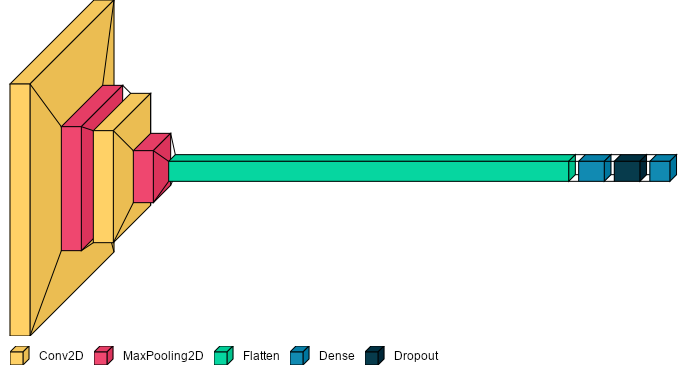

In [19]:
import visualkeras
from PIL import ImageFont
cnn.summary()
visualkeras.layered_view(cnn, legend=True)
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(cnn, legend=True, font=font, to_file='model_layered.png')

Konečne prechádzame k trénovaniu neurónovej siete. Ako vidíme, nastavujeme trénovaciu a testovaciu (validačnú) množinu, ktoré sme si vyššie vytvárali. Počet epoch pre rýchlosť dáme pomerne nízky a to 25.
Keď príkaz zbehne, tak vidíme hodnoty accuracy, čo je presnosť pre trénovaciu množinu a val_accuracy, čo je presnosť pre testovaciu množinu. Ak je presnosť pre trénovaciu množinu veľmi vysoká, avšak nízka pre testovaciu, znamená to, že sieť je pretrénovaná (overfitting).

In [20]:
# Training the CNN on the Training set and evaluating it on the Test set
hist = cnn.fit(x = training_set, validation_data = test_set, epochs = 30)

Epoch 1/30
125/125 [==============================] - 49s 374ms/step - loss: 1.5578 - accuracy: 0.2002 - val_loss: 1.3263 - val_accuracy: 0.2500
Epoch 2/30
125/125 [==============================] - 46s 367ms/step - loss: 1.3883 - accuracy: 0.1262 - val_loss: 1.3853 - val_accuracy: 0.2642
Epoch 3/30
125/125 [==============================] - 46s 365ms/step - loss: 1.3676 - accuracy: 0.3207 - val_loss: 1.2630 - val_accuracy: 0.2942
Epoch 4/30
125/125 [==============================] - 46s 369ms/step - loss: 1.1907 - accuracy: 0.4638 - val_loss: 1.0153 - val_accuracy: 0.5683
Epoch 5/30
125/125 [==============================] - 46s 371ms/step - loss: 1.0230 - accuracy: 0.5270 - val_loss: 1.2588 - val_accuracy: 0.5383
Epoch 6/30
125/125 [==============================] - 46s 364ms/step - loss: 0.9328 - accuracy: 0.6085 - val_loss: 1.1165 - val_accuracy: 0.5450
Epoch 7/30
125/125 [==============================] - 46s 364ms/step - loss: 0.8365 - accuracy: 0.6475 - val_loss: 0.8293 - val_ac

Dalej si vykreslime grafy reprezentujuce presnost trenovacich a testovacich dat a ich straty.

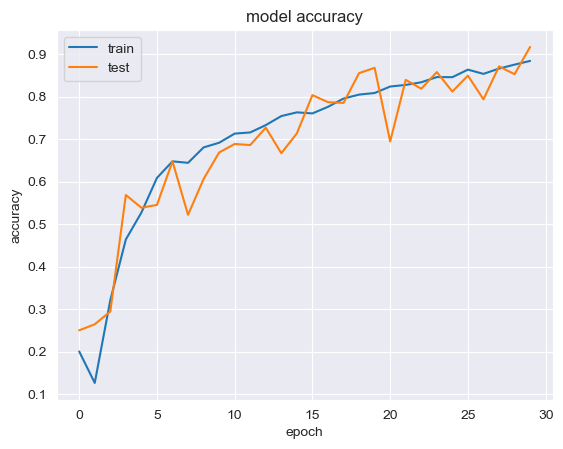

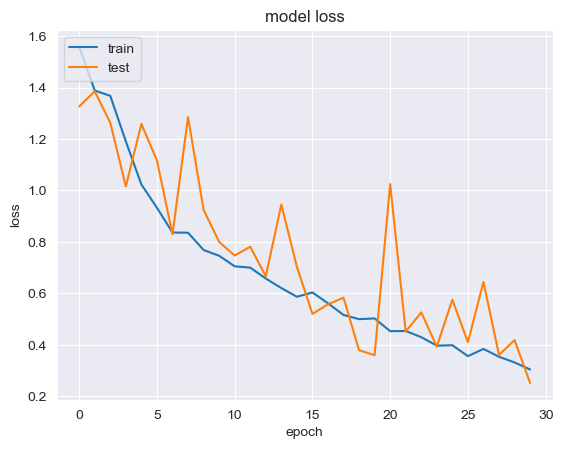

In [21]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.jpg',dpi=500)
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.jpg',dpi=500)
plt.show()

In [22]:
import numpy as np
print(test_set.class_indices)
predictions = cnn.predict(test_set)
print(predictions)
predictions = np.argmax(predictions, axis = 1)
print(predictions)

{'buffalo': 0, 'elephant': 1, 'rhino': 2, 'zebra': 3}
38/38 [==============================] - 5s 115ms/step
[[8.0081218e-01 2.5104119e-02 1.7318361e-01 9.0003258e-04]
 [9.9999976e-01 1.7501242e-07 3.5439232e-10 9.0366264e-08]
 [3.8805720e-01 4.0204161e-01 1.5137085e-01 5.8530360e-02]
 ...
 [3.4335076e-03 9.4761867e-03 1.3068829e-02 9.7402149e-01]
 [6.8353447e-09 2.3372742e-08 4.8549264e-08 1.0000000e+00]
 [4.2387276e-09 5.2904898e-08 3.4931106e-06 9.9999654e-01]]
[0 0 1 ... 3 3 3]


Teraz spravime predikciu pre jeden konkrétny obrázok z kazdej triedy. Po načítaní potrebných knižníc je vybraný konkrétny obrázok na disku, pričom target_size je veľkosť, akú sme využívali vyššie, teda 64x64. Potrebujeme obrázok konvertovať na pole, keďže toto je očakávaný formát vstupu. Podľa vypísanej informácie o príslušnosti čísla triedy ku konkrétnej triede bufalo/slon/nosorozec/zebra si vypíšeme triedu nášho predikovaného obrázka.

In [23]:
# Making a single prediction
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# fruits = {0: "apple" , 1: "banana" , 2: "grape", 3: "strawberry"}
# flowers = {0: 'bellflower', 1: 'common_daisy', 2: 'dandelion', 3: 'sunflower'}
animals = {0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra'}

# test_image = load_img('dataset/valid/Apple/apple.jpeg', target_size = (64, 64))
# test_image = load_img('dataset2/valid/bellflower.jpg', target_size = (64, 64))
test_image = load_img('dataset3/valid/buffalo.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image/255.0)
prediction1 = np.argmax(result, axis = 1).astype(int)
print('In the file buffalo.jpg is:', animals[prediction1[0]])

# test_image = load_img('dataset/valid/Banana/banana.jpeg', target_size = (64, 64))
# test_image = load_img('dataset2/valid/common_daisy.jpg', target_size = (64, 64))
test_image = load_img('dataset3/valid/elephant.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image/255.0)
prediction2 = np.argmax(result, axis = 1).astype(int)
print('In the file elephant.jpg is:', animals[prediction2[0]])

# test_image = load_img('dataset/valid/Grape/grape.jpeg', target_size = (64, 64))
# test_image = load_img('dataset2/valid/dandelion.jpg', target_size = (64, 64))
test_image = load_img('dataset3/valid/rhino.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image/255.0)
prediction3 = np.argmax(result, axis = 1).astype(int)
print('In the file rhino.jpg is:', animals[prediction3[0]])

# test_image = load_img('dataset/valid/Strawberry/strawberry.jpeg', target_size = (64, 64))
# test_image = load_img('dataset2/valid/sunflower.jpg', target_size = (64, 64))
test_image = load_img('dataset3/valid/zebra.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image/255.0)
prediction4 = np.argmax(result, axis = 1).astype(int)
print('In the file zebra.jpg is:', animals[prediction4[0]])

1/1 [==============================] - 0s 81ms/step
In the file buffalo.jpg is: buffalo
1/1 [==============================] - 0s 31ms/step
In the file elephant.jpg is: elephant
1/1 [==============================] - 0s 28ms/step
In the file rhino.jpg is: rhino
1/1 [==============================] - 0s 33ms/step
In the file zebra.jpg is: zebra


Dalej si vpiseme text predikcie do obrazkov.

In [24]:
from PIL import ImageFont, ImageDraw, Image

image = Image.open('dataset3/valid/buffalo.jpg')
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('arial.ttf', 30)
draw.text((10, 20), animals[prediction1[0]], font=font, fill=(111, 255, 0))
image.show()

image = Image.open('dataset3/valid/elephant.jpg')
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('arial.ttf', 30)
draw.text((10, 20), animals[prediction2[0]], font=font, fill=(111, 255, 0))
image.show()

image = Image.open('dataset3/valid/rhino.jpg')
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('arial.ttf', 30)
draw.text((10, 20), animals[prediction3[0]], font=font, fill=(111, 255, 0))
image.show()

image = Image.open('dataset3/valid/zebra.jpg')
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('arial.ttf', 30)
draw.text((10, 20), animals[prediction4[0]], font=font, fill=(111, 255, 0))
image.show()

Teraz si vypiseme podrobne statistiky o nasej CNN a vykreslime jej konfuznu maticu. Z nej vieme napriklad vycitat, ktore zvierata si nasa CNN medzi sebou mylila najcastejsie.

38/38 [==============================] - 5s 120ms/step - loss: 0.2519 - accuracy: 0.9167
test loss, test acc: [0.25186097621917725, 0.9166666865348816]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       300
           1       0.96      0.81      0.88       300
           2       0.88      0.91      0.90       300
           3       0.91      1.00      0.95       300

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200


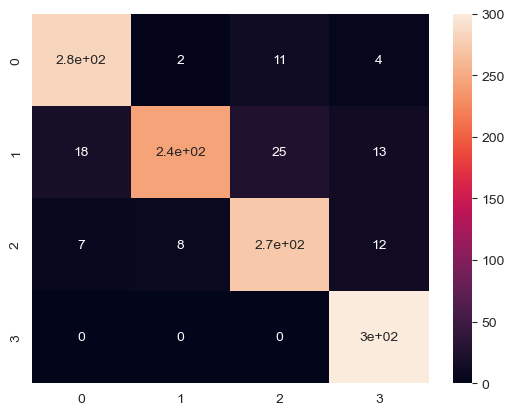

In [25]:
# vypis presnosti cez evalute
results_validation = cnn.evaluate(test_set, batch_size=32)
print("test loss, test acc:", results_validation)

# vypis presnosti cez accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

accuracy_score(test_set.classes, predictions)
cm = confusion_matrix(test_set.classes, predictions)

sns.heatmap(cm, annot=True)
print(classification_report(test_set.classes, predictions))

Model CNN a jej vahy si ulozime do suborov, aby sme ju mohli prepouzit aj v dalsich experimentoch bez nutnosti ju zakazdym nanovo trenovat.

In [26]:
model_json = cnn.to_json()

with open('cnn0.json','w') as json_file:
    json_file.write(model_json)

from keras.models import save_model
network_saved = save_model(cnn, 'weights0.hdf5')

with open('cnn.json', 'r') as json_file:
    json_saved_model = json_file.read()
    print(json_saved_model)

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_2_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 64, 64, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null,

C:\Users\horni\AppData\Local\Temp\ipykernel_21276\15444896.py:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(cnn, 'weights0.hdf5')


Tymto kodom nacitame model a vahy ulozene CNN.

In [3]:
with open('cnn.json', 'r') as json_file:
    json_saved_model = json_file.read()
    print(json_saved_model)
cnn = tf.keras.models.model_from_json(json_saved_model)
cnn.load_weights('weights.hdf5')
cnn.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
cnn.summary()

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_2_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 64, 64, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null,